In [1]:
import sys
import os
import seaborn as sns
from dotenv import load_dotenv
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Update the connection details with your own values
host = 'localhost'
port = '5432'
database = 'postgres'
user = 'postgres'
password = 'pass123'



In [3]:
def connect():
    conn = None
    try:
        print('Connecting..')
        conn = psycopg2.connect(
              host=host,
              database=database,
              user=user,
              password=password
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        sys.exit(1)   
        
    print("All good, Connection successful!")
    return conn

In [4]:
def sql_to_dataframe(conn, query):
    """Import data from a PostgreSQL database using a SELECT query"""
    cursor = conn.cursor()   
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    # The execute returns a list of tuples:   
    tuples_list = cursor.fetchall()   
    
    # Now we need to transform the list into a pandas DataFrame:   
    df = pd.DataFrame(tuples_list, columns=[col[0] for col in cursor.description])
    cursor.close()   
    return df

In [5]:
# create query
query = """ SELECT * FROM public.xdr_data  """

#opening the connection
conn = connect()

#loading our dataframe
df = sql_to_dataframe(conn, query)

#closing the connection
conn.close()

Connecting..
All good, Connection successful!


In [6]:
# Let’s see if we loaded the df successfully
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
#Aggregate information per customer
# Treat missing values by replacing with the mean or mode
df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean(), inplace=True)
df['Avg RTT UL (ms)'].fillna(df['Avg RTT UL (ms)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
df['Handset Type'].fillna(df['Handset Type'].mode()[0], inplace=True)

In [9]:
# Aggregate the required information per customer
aggregated_df = df.groupby('MSISDN/Number').agg({'Avg Bearer TP DL (kbps)': 'mean',
                                                 'Avg RTT DL (ms)': 'mean',
                                                 'Handset Type': 'first',
                                                 'TCP DL Retrans. Vol (Bytes)': 'mean'})

In [10]:
# Compute and list top, bottom, and most frequent values

# TCP values
top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

In [11]:
# RTT values
top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
most_frequent_rtt = df['Avg RTT DL (ms)'].value_counts().head(10)

In [12]:
# Throughput values
top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP DL (kbps)'].value_counts().head(10)

In [13]:
# Compute and report

# Distribution of average throughput per handset type
throughput_distribution = df.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean()

# Average TCP retransmission view per handset type
tcp_retransmission_view = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean()

# Print the results
print(" Aggregated information per customer:")
print(aggregated_df)

print("\n Top, bottom, and most frequent values:")
print("Top 10 TCP values:")
print(top_10_tcp)
print("Bottom 10 TCP values:")
print(bottom_10_tcp)
print("Most frequent TCP values:")
print(most_frequent_tcp)

print("\nTop 10 RTT values:")
print(top_10_rtt)
print("Bottom 10 RTT values:")
print(bottom_10_rtt)
print("Most frequent RTT values:")
print(most_frequent_rtt)

print("\nTop 10 Throughput values:")
print(top_10_throughput)
print("Bottom 10 Throughput values:")
print(bottom_10_throughput)
print("Most frequent Throughput values:")
print(most_frequent_throughput)

print("\n Distribution of average throughput per handset type:")
print(throughput_distribution)

print("\n - Average TCP retransmission view per handset type:")
print(tcp_retransmission_view)

 Aggregated information per customer:
               Avg Bearer TP DL (kbps)  Avg RTT DL (ms)  \
MSISDN/Number                                             
3.360100e+10                      37.0        46.000000   
3.360100e+10                      48.0        30.000000   
3.360100e+10                      48.0       109.795706   
3.360101e+10                     204.0        69.000000   
3.360101e+10                   20197.5        57.000000   
...                                ...              ...   
3.379000e+10                    9978.0        42.000000   
3.379000e+10                      68.0        34.000000   
3.197021e+12                       1.0       109.795706   
3.370000e+14                      11.0       109.795706   
8.823971e+14                       2.0       109.795706   

                                   Handset Type  TCP DL Retrans. Vol (Bytes)  
MSISDN/Number                                                                 
3.360100e+10     Huawei P20 Lite Hua

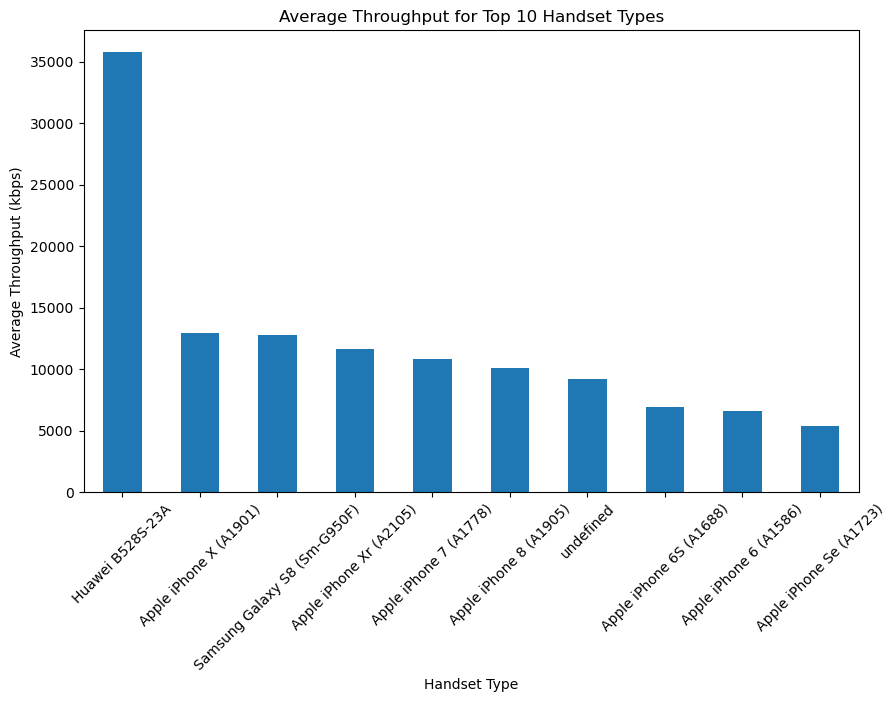

In [15]:
# Bar chart for average throughput per handset type
plt.figure(figsize=(10, 6))
top_10_handsets = df['Handset Type'].value_counts().head(10)
top_10_throughput = df[df['Handset Type'].isin(top_10_handsets.index)]
throughput_chart = top_10_throughput.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean().sort_values(ascending=False)
throughput_chart.plot(kind='bar')
plt.title('Average Throughput for Top 10 Handset Types')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput (kbps)')
plt.xticks(rotation=45)
plt.show()

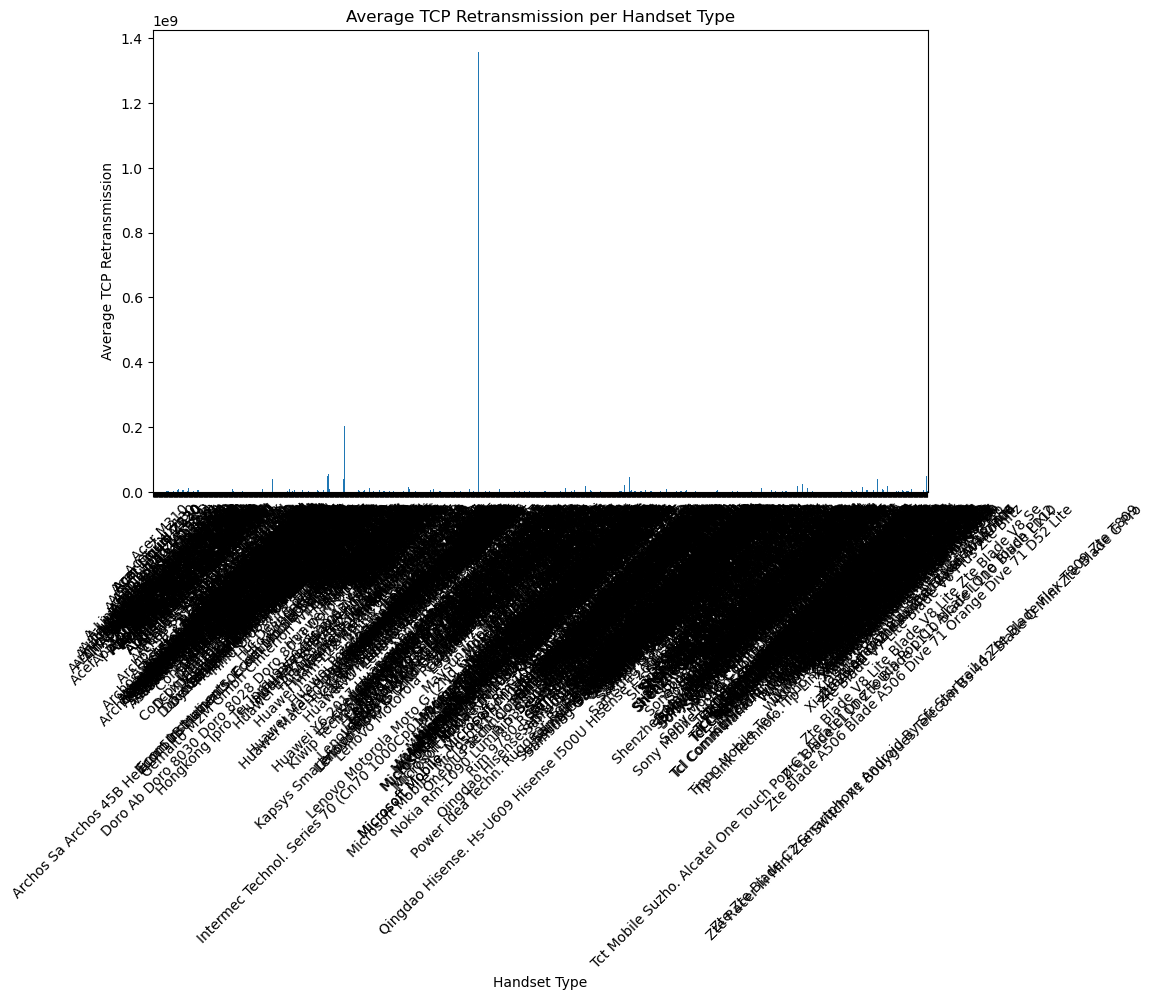

In [16]:
# Bar chart for average TCP retransmission per handset type
plt.figure(figsize=(10, 6))
tcp_retransmission_view.plot(kind='bar')
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission')
plt.xticks(rotation=45)
plt.show()